In [1]:
import pandas as pd
import numpy as np
import os, sys, pickle

sys.path.append("..")
from config import DATA_PATH

In [35]:
with open(f'{DATA_PATH}/features-word.pkl', "rb") as f:
    dataset = pickle.load(f)

In [36]:
print(dataset.columns)
count = dataset['kind'].value_counts()
n_text   = count['O']
n_theorems = sum(x for k,x in count.items() if 'Theorem' in k)
n_begin_theorems = count['B-Theorem']
n_result = sum(x for k,x in count.items() if k != 'O')
print(n_text, n_result, n_theorems, n_begin_theorems)
print(count)
papers = dataset['from'].unique()
print(len(papers))
dataset.describe()

Index(['delta_v', 'delta_h', 'next_delta_h', 'first_word', 'last_word',
       'italic', 'math', 'bold', 'fontsize', 'text', 'kind', 'result', 'from'],
      dtype='object')
5235627 406337 147056 2686
O                5235627
I-Theorem         144370
I-Lemma           122764
I-Definition      104075
I-Proposition      28534
B-Theorem           2686
B-Lemma             2116
B-Definition        1244
B-Proposition        548
Name: kind, dtype: int64
428


,delta_v,delta_h,next_delta_h,fontsize,result
count,5.641964e+06,5.641964e+06,5.641964e+06,5.641964e+06,406337.000000
mean,1.621492e+01,5.408530e+00,5.097032e+00,1.016139e+01,16.790312
std,7.449712e+03,2.366608e+01,3.494335e+01,1.964463e+00,15.722878
min,0.000000e+00,-1.459790e+02,-5.569677e+02,0.000000e+00,1.000000
25%,2.303600e+00,2.309600e+00,2.259775e+00,9.963000e+00,5.000000
50%,3.854000e+00,3.317100e+00,3.316600e+00,1.090900e+01,12.000000
75%,6.592800e+00,3.915600e+00,3.908800e+00,1.090900e+01,23.000000
max,9.999999e+06,5.084330e+02,5.323980e+02,4.184200e+01,114.000000


# Equilibrage du jeu de données.

In [37]:
prediction_mode = "theorem-only"

def is_theorem(x):
    return (x.kind == "I-Theorem") | (x.kind == "B-Theorem")

def sample_dataset(dataset):
    n_sample = n_theorems # number of results.
    
    n_sample_per_theorem = 4 * n_sample // n_begin_theorems
    print("Samples per theorem:", n_sample_per_theorem)
    
    near_theorem = is_theorem(dataset).rolling(n_sample_per_theorem, min_periods=1, center=True).max()
    print(dataset[near_theorem == 1.])
    return dataset[near_theorem == 1.]


filtered_dataset = sample_dataset(dataset)
    
if prediction_mode == "theorem-only":
    replacement = {}
    
    for k in ['Theorem']:
        for b in ['I', 'B']:
            replacement[f"{b}-{k}"] = b
    for k in ['Lemma', 'Definition', 'Proposition']:
        for b in ['I', 'B']:
            replacement[f"{b}-{k}"] = 'O'
    
        
        
filtered_dataset.replace(replacement, inplace=True)
filtered_dataset['kind'].value_counts()

Samples per theorem: 218
         delta_v   delta_h  next_delta_h  first_word  last_word  italic  \
701       6.9660    1.8209        0.0005       False       True   False   
702       0.0000    0.0000        0.0000        True       True   False   
703       0.0000  272.6370       15.8299        True      False   False   
704       0.0000   15.8299        2.3172       False      False   False   
705       0.0000    2.3172        0.0004       False      False   False   
706       0.0000    0.0004        0.4982       False      False   False   
707       0.0000    0.4982       -0.0005       False      False   False   
708       0.0000   -0.0005        7.7712       False      False   False   
709       0.0000    7.7712        3.6323       False      False   False   
710       0.0000    3.6323        3.0979       False      False   False   
711       0.0000    3.0979        2.9569       False      False   False   
712       0.0000    2.9569        0.0034       False       True   False   


/home/lucas/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


O    502213
I    144370
B      2686
Name: kind, dtype: int64

# Ajout des features textuelles.

* Is digit
* Is upper
* Is title
* Is ascii
* word.lower()[:3]
* word.lower()[-3:]
* length
* word.lower()

In [39]:
text = filtered_dataset['text']
filtered_dataset['is_digit'] = text.apply(lambda x: x.isdigit())
filtered_dataset['is_upper'] = text.apply(lambda x: x.isupper())
filtered_dataset['is_title'] = text.apply(lambda x: x.istitle())
filtered_dataset['is_ascii'] = text.apply(lambda x: x.isascii())
filtered_dataset['len']      = text.apply(lambda x: len(x))
filtered_dataset['word']     = text.apply(lambda x: x.lower())
filtered_dataset['word[:3]'] = filtered_dataset['word'].apply(lambda x: x[:3])
filtered_dataset['word[-3:]']= filtered_dataset['word'].apply(lambda x: x[-3:])

/home/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [40]:
filtered_dataset

,delta_v,delta_h,next_delta_h,first_word,last_word,italic,math,bold,fontsize,text,...,result,from,is_digit,is_upper,is_title,is_ascii,len,word,word[:3],word[-3:]
701,6.9660,1.8209,0.0005,False,True,False,True,False,10.909,c,...,NaN,1004.0436,False,False,False,True,1,c,c,c
702,0.0000,0.0000,0.0000,True,True,False,False,False,7.970,def,...,NaN,1004.0436,False,False,False,True,3,def,def,def
703,0.0000,272.6370,15.8299,True,False,False,False,False,10.909,=,...,NaN,1004.0436,False,False,False,True,1,=,=,=
704,0.0000,15.8299,2.3172,False,False,False,True,False,7.970,i,...,NaN,1004.0436,False,False,False,True,1,i,i,i
705,0.0000,2.3172,0.0004,False,False,False,True,False,10.909,x,...,NaN,1004.0436,False,False,False,True,1,x,x,x
706,0.0000,0.0004,0.4982,False,False,False,True,False,7.970,i,...,NaN,1004.0436,False,False,False,True,1,i,i,i
707,0.0000,0.4982,-0.0005,False,False,False,True,False,10.909,c,...,NaN,1004.0436,False,False,False,True,1,c,c,c
708,0.0000,-0.0005,7.7712,False,False,False,True,False,7.970,i,...,NaN,1004.0436,False,False,False,True,1,i,i,i
709,0.0000,7.7712,3.6323,False,False,False,False,False,10.909,mod,...,NaN,1004.0436,False,False,False,True,3,mod,mod,mod
710,0.0000,3.6323,3.0979,False,False,False,False,False,10.909,"2,",...,NaN,1004.0436,False,False,False,True,2,"2,","2,","2,"


In [41]:
filtered_dataset.columns

Index(['delta_v', 'delta_h', 'next_delta_h', 'first_word', 'last_word',
       'italic', 'math', 'bold', 'fontsize', 'text', 'kind', 'result', 'from',
       'is_digit', 'is_upper', 'is_title', 'is_ascii', 'len', 'word',
       'word[:3]', 'word[-3:]'],
      dtype='object')

In [42]:
n_train = int(0.8*len(papers))
n_test  = len(papers) - n_train
np.random.shuffle(papers)
papers_train = papers[:n_train]
papers_test  = papers[n_train:n_train + n_test]

In [43]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

# Set the parameters of the model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
        
    c1 = 1.000,
    c2 = 0.000,
    
    max_iterations=100,
    
    # whether to include transitions that
    # are possible, but not observed
    all_possible_transitions=False
)

In [44]:

def get_features(paper):
    global filtered_dataset
    
    data = filtered_dataset[filtered_dataset['from']==paper]
    X_features = data.drop(['from', 'text', 'kind', 'result'], axis=1)
    
    
    numeric_cols = ['delta_v', 'delta_h', 'next_delta_h', 'fontsize', 'len']
    
    X_mean = X_features[numeric_cols].rolling(64, min_periods=1, center=True).mean()
    X_std  = X_features[numeric_cols].rolling(64, min_periods=1, center=True).std()
    
    X_features[numeric_cols] = ((X_features - X_mean)/(X_std + 1e-12))[numeric_cols]
        
        
    boolean_cols = ['first_word', 'last_word', 'italic', 'math', 'bold','is_digit', 'is_upper', 'is_title', 'is_ascii']
    X_features[boolean_cols] = 2*X_features[boolean_cols] - 1
    
    X_features = X_features.to_dict('records')
    
    if len(X_features) == 0:
        return [], []
    keys = X_features[0].keys()
    
    X = []
    
    for i, entry in enumerate(X_features):
        sample = {}
        for key in keys:
            prec_value = X_features[i-1][key] if i > 0 else 0
            value = entry[key]
            next_value = X_features[i+1][key] if i < len(X_features)-1 else 0

            sample["value_"+key] = value
            
            if key in numeric_cols + boolean_cols:
                sample["prec_"+key]  = prec_value - value
                sample["next_"+key]  = next_value - value
            else:
                sample["prec_"+key]  = prec_value
                sample["next_"+key]  = next_value
        X.append(sample)
    
    y = list(data['kind'])
    return X,y

In [45]:
from tqdm.notebook import tqdm


X,y = zip(*[get_features(paper) for paper in tqdm(papers_train)])


In [46]:
crf.fit(X, y)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=1.0, c2=0.0, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [47]:
X_test,y_test = zip(*[get_features(paper) for paper in tqdm(papers_test)])

In [48]:
y_pred_train = crf.predict(X)
y_pred_test = crf.predict(X_test)

In [49]:
print("Train")
print(metrics.flat_classification_report(y, y_pred_train, digits=2))
print("Test")
print(metrics.flat_classification_report(y_test, y_pred_test, digits=2))

Train
              precision    recall  f1-score   support

           B       0.99      0.98      0.98      2083
           I       0.99      0.96      0.97    111229
           O       0.99      1.00      0.99    391366

    accuracy                           0.99    504678
   macro avg       0.99      0.98      0.98    504678
weighted avg       0.99      0.99      0.99    504678

Test
              precision    recall  f1-score   support

           B       0.98      0.95      0.96       603
           I       0.93      0.82      0.87     33141
           O       0.95      0.98      0.97    110847

    accuracy                           0.95    144591
   macro avg       0.95      0.92      0.93    144591
weighted avg       0.94      0.95      0.94    144591



In [50]:
import eli5
eli5.show_weights(crf, top=50)

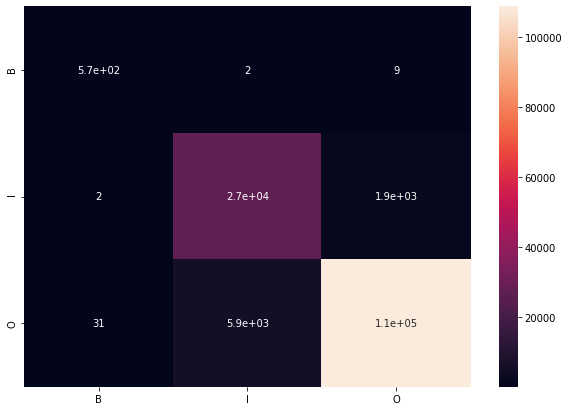

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

y_pred_test_ok = [x for y in y_pred_test for x in y]
y_test_ok      = [x for y in y_test for x in y]
labels         = sorted(list(set(y_test_ok)))
mtx = confusion_matrix(y_pred_test_ok, y_test_ok, labels)

df_cm = pd.DataFrame(mtx, index = labels,
                  columns = labels)

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# Error exploration

In [52]:
c = 0
    
for i, paper in enumerate(tqdm(papers_test)):
    pred = y_pred_test[i]
    true = y_test[i]
    
    for j,(a,b) in list(enumerate(zip(pred, true))):
        if (a == 'I' and b == 'O') or (a == 'O' and b == 'I'):
            c += 1
            entry = filtered_dataset[filtered_dataset['from']==paper].iloc[j]
            just_before = filtered_dataset[filtered_dataset['from']==paper].iloc[j-1]
            text = entry['text']
            result = entry['result']
            print(f"[{paper}] {a} instead of {b}: {text} ({result})")
            print(f"Context: ", just_before['text'], " (", just_before['result'], ")", sep="")
            #print(X_test[i])
            print("##")
    if c > 30:
        break
    

[1912.03514] O instead of I: Then, (1.0)
Context: 1). (1.0)
##
[1912.03514] O instead of I: the (1.0)
Context: Then, (1.0)
##
[1912.03514] O instead of I: M-IHS (1.0)
Context: the (1.0)
##
[1912.03514] O instead of I: applied (1.0)
Context: M-IHS (1.0)
##
[1912.03514] O instead of I: on (1.0)
Context: applied (1.0)
##
[1912.03514] O instead of I: (1.2) (1.0)
Context: on (1.0)
##
[1912.03514] O instead of I: and (1.0)
Context: (1.2) (1.0)
##
[1912.03514] O instead of I: the (1.0)
Context: and (1.0)
##
[1912.03514] O instead of I: Dual (1.0)
Context: the (1.0)
##
[1912.03514] O instead of I: M-IHS (1.0)
Context: Dual (1.0)
##
[1912.03514] O instead of I: applied (1.0)
Context: M-IHS (1.0)
##
[1912.03514] O instead of I: on (1.0)
Context: applied (1.0)
##
[1912.03514] O instead of I: (3.2) (1.0)
Context: on (1.0)
##
[1912.03514] O instead of I: with (1.0)
Context: (3.2) (1.0)
##
[1912.03514] O instead of I: ﬁxed (1.0)
Context: with (1.0)
##
[1912.03514] O instead of I: momentum (1.0)
Cont

[1912.03514] O instead of I: value (1.0)
Context: singular (1.0)
##
[1912.03514] O instead of I: of (1.0)
Context: value (1.0)
##
[1912.03514] O instead of I: A. (1.0)
Context: of (1.0)
##
[1912.03514] I instead of O: 2 (nan)
Context: (A) (nan)
##
[1912.03514] I instead of O: /( (nan)
Context: 2 (nan)
##
[1912.03514] I instead of O: 2 (nan)
Context: /( (nan)
##
[1912.03514] I instead of O: δ) (nan)
Context: 2 (nan)
##
[1912.03514] I instead of O: and (nan)
Context: δ) (nan)
##
[1912.03514] I instead of O: SA (nan)
Context: and (nan)
##
[1912.03514] I instead of O: is (nan)
Context: SA (nan)
##
[1912.03514] I instead of O: computable (nan)
Context: is (nan)
##
[1912.03514] I instead of O: in (nan)
Context: computable (nan)
##
[1912.03514] I instead of O: O(nnz(A)); (nan)
Context: in (nan)
##
[1912.03514] I instead of O: (ii) (nan)
Context: O(nnz(A)); (nan)
##
[1912.03514] I instead of O: Sparse (nan)
Context: (ii) (nan)
##
[1912.03514] I instead of O: Subspace (nan)
Context: Sparse (nan